In [1]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import islice

In [2]:
from functions.functions_under_study import var

In [3]:
# Data interpolation Enable.
iterpEnable = True
N_points = 10000
Ri = 20

In [4]:
file_list = ['uncoated', 'coated']
N = len(file_list)
import_data = np.empty(N, dtype=object)
for n, file_name in enumerate(file_list):
    import_data[n] = np.loadtxt('AP300/' + file_name + '.dat', skiprows=1)
    # Data descaling.
    import_data[n][:,var.mag_db.value] += 20*np.log10(Ri)
    import_data[n][:,var.ph_deg.value] = np.unwrap(import_data[n][:,var.ph_deg.value]*np.pi/180 + np.pi)*180/np.pi

In [5]:
data = np.empty(N, dtype=object)
for n in range(N):
    if iterpEnable:
        data[n] = np.zeros((N_points, len(var)))
        data[n][:,var.freq.value] = np.logspace(np.log10(min(import_data[n][:,var.freq.value])),
                                                np.log10(max(import_data[n][:,var.freq.value])),
                                                N_points)
        for k in islice(var, var.mag_db.value, None):
            data[n][:,k.value] = np.interp(data[n][:,var.freq.value],
                                            import_data[n][:,var.freq.value],
                                            import_data[n][:,k.value])
    else:
        data[n] = import_data[n].copy()

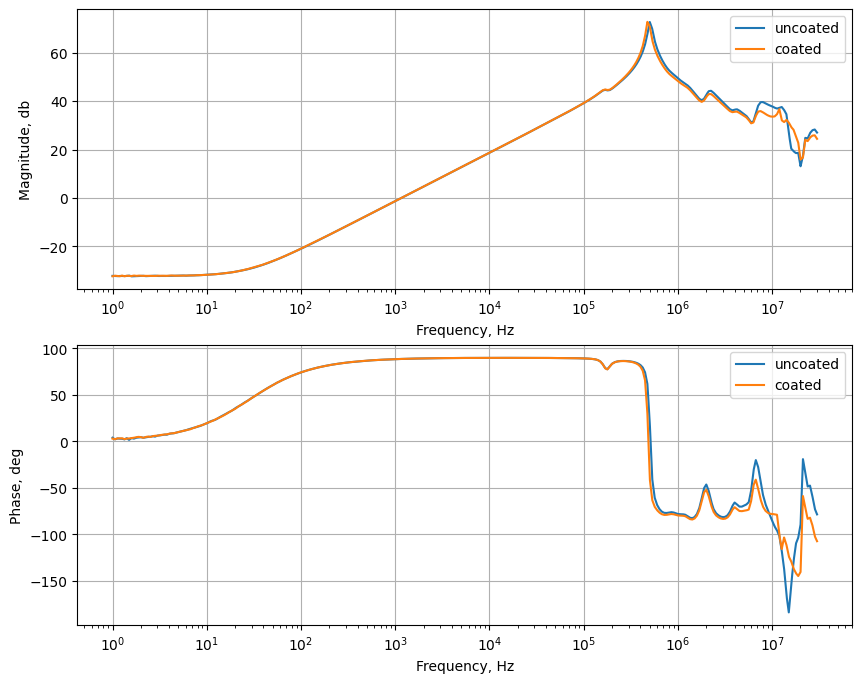

In [6]:
user_ylabel = ['Magnitude, db', 'Phase, deg']
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
for idx in range(2):
    ax = axes[idx]
    for n in range(N):
        ax.plot(data[n][:, var.freq.value], data[n][:, idx + 1], label=file_list[n])
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Frequency, Hz')
    ax.set_ylabel(user_ylabel[idx])
    ax.grid(True)

#plt.savefig('readme_img/energy_pywt.png', bbox_inches='tight')
plt.show()

In [7]:
# Parameters.
L_b = 136e-6
r_b = 25e-3
C_b = 725e-12
#C_b = 1.0
R_b = 6e3

In [8]:
from functions.functions_under_study import reactor_model_gain, reactor_model_gain_abs, loss_func, grad_func

In [9]:
N_DATA = 0
user_fontsize = 14

L_sel = 1.0
r_sel = 1.0
C_sel = 1.0

# Инициализируем коэффициенты.
w_coeff_1 = np.array([0.9, 1.1, 1.2])

In [10]:
# Принимаем шаг в 1% относительно начального приближения и вводим соответствующие приращения.
w_step = 0.00001 * w_coeff_1
w_coeff = w_coeff_1 - w_step
w_coeff_2 = w_coeff_1 + w_step

# Массивы для каждой переменной отдельно.
x1 = [w_coeff[0], w_coeff_1[0], w_coeff_2[0]]
x2 = [w_coeff[1], w_coeff_1[1], w_coeff_2[1]]
x3 = [w_coeff[2], w_coeff_1[2], w_coeff_2[2]]

# Конвертируем в сетку.
X1, X2, X3 = np.meshgrid(x1, x2, x3, indexing='ij')

# Формируем массив значений функции потерь, для вычисления градиента.
# Initialize array to store loss values.
loss_func_grad = np.zeros_like(X1)
# Compute loss at each point in the grid.
# Note: This loop can be slow for large grids. Vectorization is better if possible.
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        for k in range(X1.shape[2]):
            w_local = [X1[i,j,k], X2[i,j,k], X3[i,j,k]]
            loss_func_grad[i,j,k] = loss_func(
                freq=data[N_DATA][:, var.freq.value],
                y=data[N_DATA][:, var.mag_db.value],
                w=w_local)
# ВАЖНО! Шаг перечисляем в ПРЯМОМ порядке (в отличии от случая перечисления переменных).
grad_grid = np.gradient(loss_func_grad, w_step[0], w_step[1], w_step[2])
grad = np.zeros((len(grad_grid),))
# Выбираем значение в самом центре окрестности.
for idx, grad_axis in enumerate(grad_grid):
    grad[idx] = grad_axis[1][1,1]

grad_norm = np.linalg.norm(grad, ord=None, axis=None)

In [11]:
loss_func(
                freq=data[N_DATA][:, var.freq.value],
                y=data[N_DATA][:, var.mag_db.value],
                w=w_local) / len(data[N_DATA][:, var.freq.value])

11.768056969416127

In [12]:
grad1 = grad_func(
    freq=data[N_DATA][:, var.freq.value],
    y=data[N_DATA][:, var.mag_db.value],
    w=w_coeff_1)
grad_norm1 = np.linalg.norm(grad1, ord=None, axis=None)

In [13]:
print(grad)
print(grad1)
print(grad_norm)
print(grad_norm1)

[-426088.00476672   23823.24799758 -113844.32936514]
[-3.13284487e+09  9.52929920e+05 -1.57004820e+14]
441677.55917619437
157004820487541.16


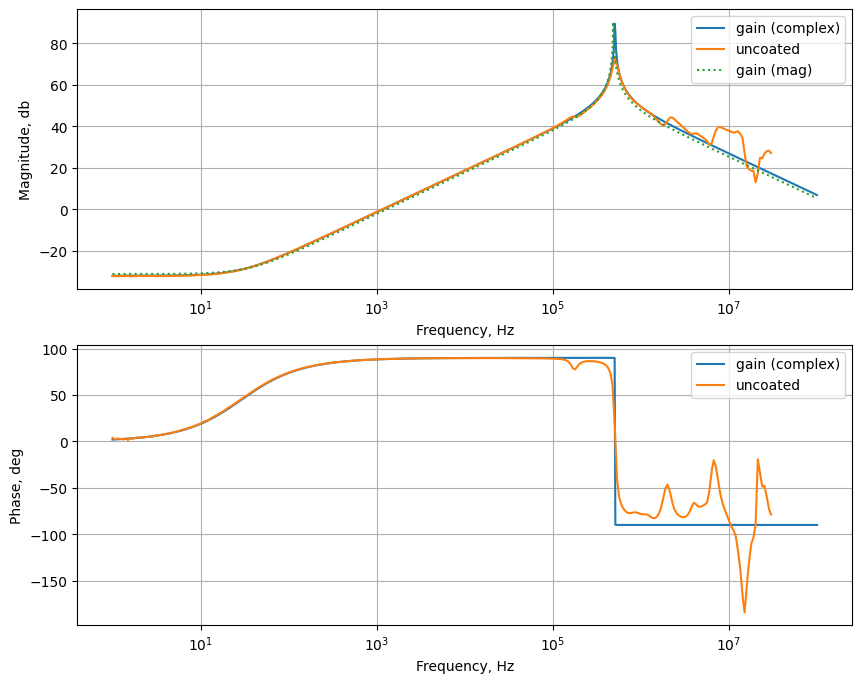

In [14]:
# Create frequency array.
N = int(1e3)
f_min = 1
f_max = 100e6
freq = np.logspace(np.log10(f_min), np.log10(f_max), N)
#freq = data[N_DATA][:, var.freq.value]

abs_phase_dataset = reactor_model_gain(    freq, L_sel*L_b, r_sel*r_b, C_sel*C_b)#, R)
abs_dataset       = reactor_model_gain_abs(freq, w_coeff_1[0]*L_b, w_coeff_1[1]*r_b, w_coeff_1[2]*C_b)#, R)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
for idx, ax in enumerate(axs):
    ax.plot(freq, abs_phase_dataset[idx], label='gain (complex)')
    ax.plot(data[N_DATA][:, var.freq.value], data[N_DATA][:, idx + 1], label=file_list[N_DATA])
    if idx == 0:
        ax.plot(freq, abs_dataset, ':', label='gain (mag)')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Frequency, Hz')
    ax.set_ylabel(user_ylabel[idx])
    ax.grid(True)
plt.show()

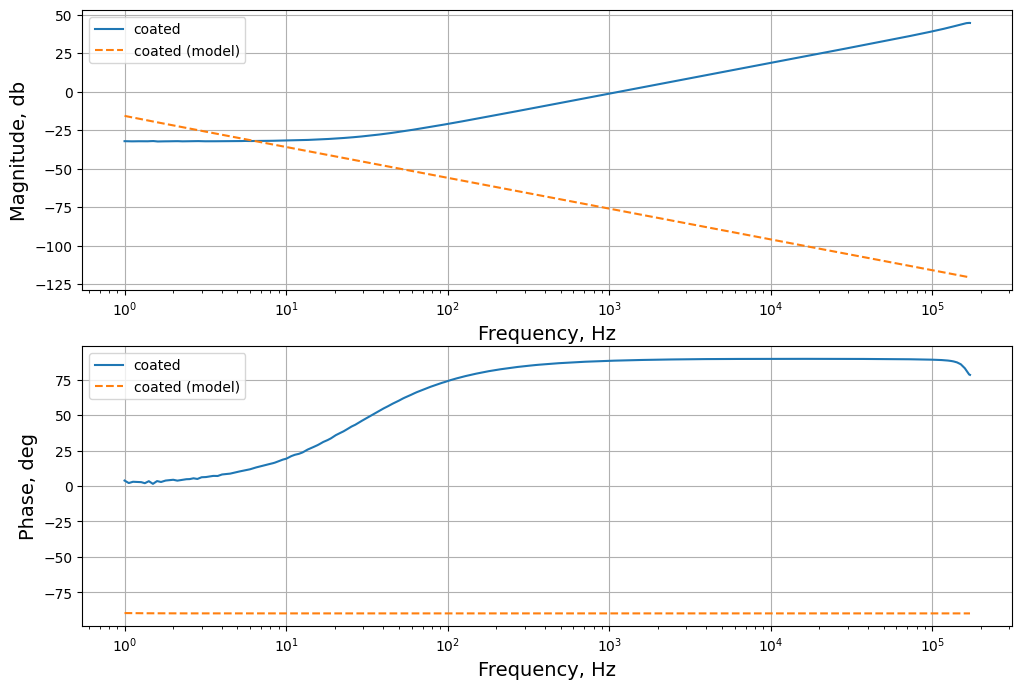

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
abs_phase_dataset = reactor_model_gain(data[N_DATA][:7000, var.freq.value], L_sel, r_sel, C_sel)

for idx, ax in enumerate(axs):
    ax.plot(data[N_DATA][:7000, var.freq.value], data[N_DATA][:7000, idx + 1], label=file_name)
    ax.plot(data[N_DATA][:7000, var.freq.value], abs_phase_dataset[idx], '--', label=file_name + ' (model)')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylabel(user_ylabel[idx], fontsize=user_fontsize)
    ax.axes.grid(True)
    ax.set_xscale('log')
    ax.legend()
plt.show()

In [16]:
def model_fit(X_train, y_train, lr_multiplier, lr_coeff, tolerance):

    iteration_max = 100000
    
    # Инициализируем коэффициенты.
    w_coeff_1 = np.array([0.9, 1.1, 1.2])

    grad = grad_func(
        freq=X_train,
        y=y_train,
        w=w_coeff_1)
    grad_norm = np.linalg.norm(grad, ord=None, axis=None)
    print(grad)

    loss = loss_func(
        freq=X_train,
        y=y_train,
        w=w_coeff_1)
    loss_arr = [loss]
    
    for i in range(iteration_max):
        learning_rate = lr_multiplier
        while (loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))) < lr_coeff * learning_rate * grad_norm**2:
            print((loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))))
            learning_rate *= lr_multiplier
        
        w_coeff_1 -= learning_rate * grad
        
        loss = loss_func(freq=X_train, y=y_train, w=w_coeff_1)
        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        loss_arr.append(loss)
        
        grad = grad_func(
            freq=X_train,
            y=y_train,
            w=w_coeff_1)
        grad_norm = np.linalg.norm(grad, ord=None, axis=None)
        print('grad:', grad)
        print('grad_norm:', grad_norm)
        print('parameters:', w_coeff_1)
        

        if grad_norm < tolerance:
            break
    
    return w_coeff_1, loss_arr

In [17]:
weights, losses = model_fit(
    X_train = data[N_DATA][:, var.freq.value],
    y_train = data[N_DATA][:, var.mag_db.value],
    lr_multiplier=0.05,
    lr_coeff = 0.05,
    tolerance=1e-2)

[-3.13284487e+09  9.52929920e+05 -1.57004820e+14]
-359485225.05391335
-275026802.2566233
-204109810.00459102
-146735264.09115013
-103272829.59101719
-67609230.21137546
-39574477.977978826
-20594571.500858888
-8647706.497319251
-2248354.8309472175
-210587.2202543431
-9047.468528473633
-704.8495097824489
8.173787520907354
0.5383868206408806
0.027254308442934416
0.001363554285489954
6.817971006967127e-05
3.409018972888589e-06
1.704611349850893e-07
8.469214662909508e-09
4.3655745685100555e-10
2.9103830456733704e-11
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

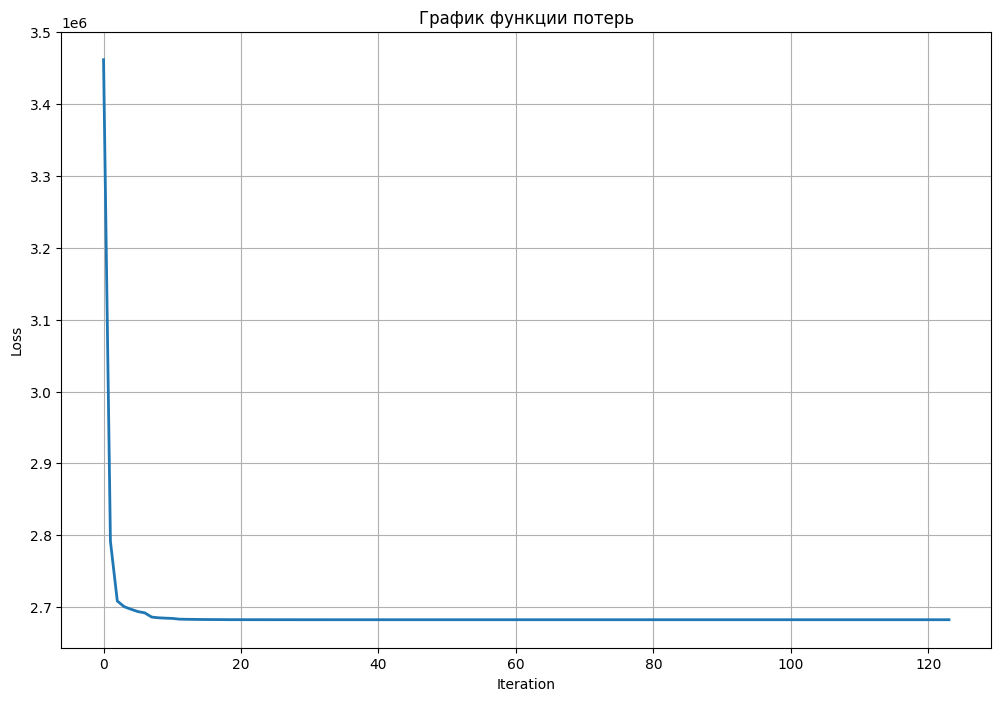

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('График функции потерь')
plt.grid()
plt.show

In [ ]:
print('Оптимальные значения коэффициентов:')
print('L=' + str(np.round(weights[0]*L_b, 8)))
print('r=' + str(np.round(weights[1]*r_b, 3)))
print('C=' + str(np.round(weights[2]*C_b, 10)))

Оптимальные значения коэффициентов:
L=4.272e-05
r=0.032
C=1.0150692805


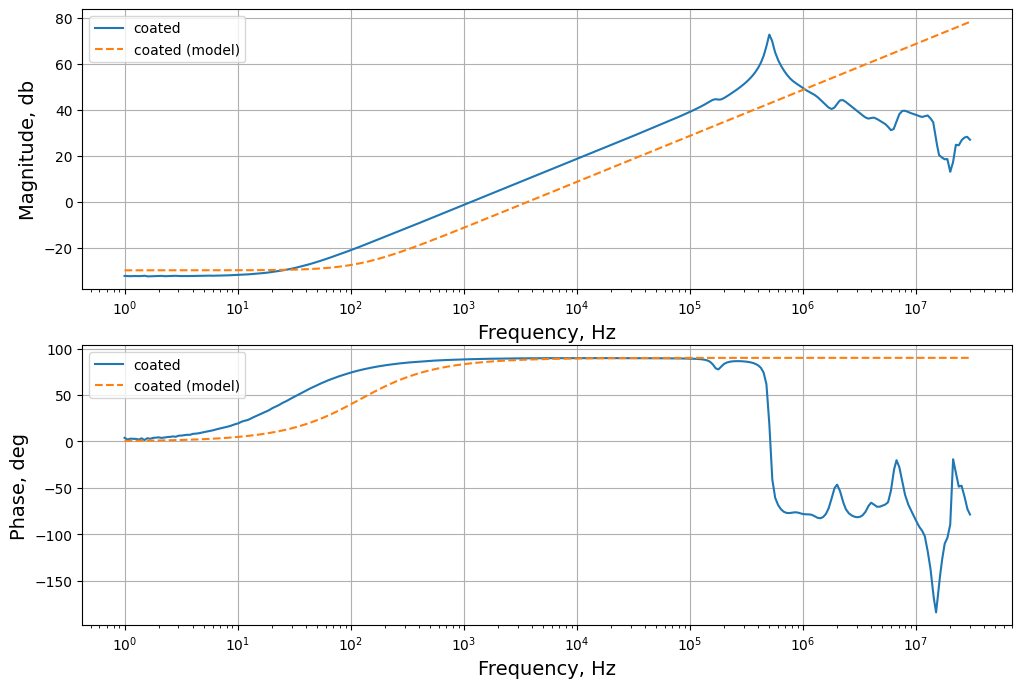

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
abs_phase_dataset = reactor_model_gain(data[N_DATA][:, var.freq.value], L=weights[0], r=weights[1], C=weights[2])

for idx, ax in enumerate(axs):
    ax.plot(data[N_DATA][:, var.freq.value], data[N_DATA][:, idx + 1], label=file_name)
    ax.plot(data[N_DATA][:, var.freq.value], abs_phase_dataset[idx], '--', label=file_name + ' (model)')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylabel(user_ylabel[idx], fontsize=user_fontsize)
    ax.axes.grid(True)
    ax.set_xscale('log')
    ax.legend()
plt.show()

In [ ]:
'''
def model_fit(X_train, y_train, lr_multiplier, lr_coeff, tolerance):

    iteration_max = 100000
    
    # Инициализируем коэффициенты.
    w_coeff_1 = np.array([0.9, 1.1, 1.2])
    # Принимаем шаг в 1% относительно начального приближения и вводим соответствующие приращения.
    w_step = 0.01 * w_coeff_1
    w_coeff = w_coeff_1 - w_step
    w_coeff_2 = w_coeff_1 + w_step
    
    # Массивы для каждой переменной отдельно.
    x1 = [w_coeff[0], w_coeff_1[0], w_coeff_2[0]]
    x2 = [w_coeff[1], w_coeff_1[1], w_coeff_2[1]]
    x3 = [w_coeff[2], w_coeff_1[2], w_coeff_2[2]]

    # Конвертируем в сетку.
    X1, X2, X3 = np.meshgrid(x1, x2, x3, indexing='ij')
    
    # Формируем массив значений функции потерь, для вычисления градиента.
    # Initialize array to store loss values.
    loss_func_grad = np.zeros_like(X1)
    # Compute loss at each point in the grid.
    # Note: This loop can be slow for large grids. Vectorization is better if possible.
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            for k in range(X1.shape[2]):
                w_local = [X1[i,j,k], X2[i,j,k], X3[i,j,k]]
                loss_func_grad[i,j,k] = loss_func(
                    freq=X_train,
                    y=y_train,
                    w=w_local)
    print(loss_func_grad)
    # ВАЖНО! Шаг перечисляем в ПРЯМОМ порядке (в отличии от случая перечисления переменных).
    grad_grid = np.gradient(loss_func_grad, w_step[0], w_step[1], w_step[2])
    grad = np.zeros((len(grad_grid),))
    # Выбираем значение в самом центре окрестности.
    for idx, grad_axis in enumerate(grad_grid):
        grad[idx] = grad_axis[1][1,1]
    
    print(grad)
    
    grad_norm = np.linalg.norm(grad, ord=None, axis=None)
    
    loss = loss_func(
                    freq=X_train,
                    y=y_train,
                    w=w_coeff_1)
    loss_arr = [loss]
    
    for i in range(iteration_max):
        '''
        if i==0:
            learning_rate = np.array([1.0]*len(grad))*0.00001
        else:
            learning_rate = np.array([1.0]*len(grad))*lr_multiplier

        lr_norm = np.linalg.norm(learning_rate, ord=None, axis=None)
        while (loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1+learning_rate*grad))) < lr_coeff * lr_norm * grad_norm**2:
            learning_rate *= lr_multiplier
            lr_norm = np.linalg.norm(learning_rate, ord=None, axis=None)

        print('center',loss_func(freq=X_train, y=y_train, w=w_coeff_1))
                print('higher', loss_func(freq=X_train, y=y_train, w=(w_coeff_1+learning_rate*grad)))
                print('lower', loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad)))
                break
                
        
        learning_rate = np.array([1.0]*len(grad))*lr_multiplier**20
        for k in range(len(learning_rate)):
            lr_norm = np.linalg.norm(learning_rate, ord=None, axis=None)
            while (loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))) < lr_coeff * lr_norm * grad_norm**2:
                print((loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))))
                learning_rate[k] *= lr_multiplier
                
                lr_norm = np.linalg.norm(learning_rate, ord=None, axis=None)
        '''
        learning_rate = lr_multiplier
        while (loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))) < lr_coeff * learning_rate * grad_norm**2:
            print((loss - loss_func(freq=X_train, y=y_train, w=(w_coeff_1-learning_rate*grad))))
            learning_rate *= lr_multiplier
        
        
        # Шаг градиентного спуска на основе значений градиента, вычисленных на предыдущем шаге.
        w_step = - learning_rate * grad
        print('w_step:', w_step)
        w_coeff = w_coeff_1.copy()
        w_coeff_1 += w_step
        w_coeff_2 = w_coeff + 2*w_step

        # Массивы для каждой переменной отдельно.
        x1 = [w_coeff[0], w_coeff_1[0], w_coeff_2[0]]
        x2 = [w_coeff[1], w_coeff_1[1], w_coeff_2[1]]
        x3 = [w_coeff[2], w_coeff_1[2], w_coeff_2[2]]
        
        # Конвертируем в сетку.
        X1, X2, X3 = np.meshgrid(x1, x2, x3, indexing='ij')
        
        # Формируем массив значений функции потерь, для вычисления градиента.
        # Initialize array to store loss values.
        loss_func_grad = np.zeros_like(X1)
        # Compute loss at each point in the grid.
        # Note: This loop can be slow for large grids. Vectorization is better if possible.
        for i in range(X1.shape[0]):
            for j in range(X1.shape[1]):
                for k in range(X1.shape[2]):
                    w_local = [X1[i,j,k], X2[i,j,k], X3[i,j,k]]
                    loss_func_grad[i,j,k] = loss_func(
                        freq=X_train,
                        y=y_train,
                        w=w_local)
        
        # ВАЖНО! Шаг перечисляем в ПРЯМОМ порядке (в отличии от случая перечисления переменных).
        grad_grid = np.gradient(loss_func_grad, w_step[0], w_step[1], w_step[2])
        grad = np.zeros((len(grad_grid),))        
        # Выбираем значение в самом центре окрестности.
        for idx, grad_axis in enumerate(grad_grid):
            grad[idx] = grad_axis[1][1,1]
        grad_norm = np.linalg.norm(grad, ord=None, axis=None)
        print('grad:', grad)
        print('grad_norm:', grad_norm)
        print('parameters:', w_coeff_1)
        
        loss = loss_func(freq=X_train, y=y_train, w=w_coeff_1)
        
        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        loss_arr.append(loss)

        if grad_norm < tolerance:
            break
    
    return w_coeff_1, loss_arr
'''